In [1]:
import torch
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import itertools
import pdb
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys

sys.path.insert(0, './src')

from data import Dataset
from kernels import HMC_our, HMC_vanilla, Reverse_kernel
from models import Gen_network, Inf_network, Inf_network_simple, Gen_network_simple
from target import NN_bernoulli, GMM_target, NN_Gaussian
from utils import plot_digit_samples, get_samples
from args import get_args

In [2]:
torchType = torch.float32

In [3]:
def set_seeds(rand_seed):
    torch.cuda.manual_seed_all(rand_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(rand_seed)
    np.random.seed(rand_seed)
    random.seed(rand_seed)

seed = 1 # 1337 #
set_seeds(seed)

In [4]:
args = get_args()

args.data = "mnist"
args.z_dim = 64
args.data_distrib = GMM_target(args, args.device)

In [5]:
if args.data == 'toy_data':
    encoder = Inf_network_simple(kwargs=args).to(args.device)
    target = NN_Gaussian(kwargs=args, model=Gen_network_simple(args.z_dim, args), device=args.device).to(args.device)   
else:
    encoder = Inf_network(kwargs=args).to(args.device)
    target = NN_bernoulli(kwargs=args, model=Gen_network(args.z_dim, args), device=args.device).to(args.device)

if args.learnable_reverse:
    reverse_kernel = Reverse_kernel(kwargs=args).to(args.device)
    reverse_params = reverse_kernel.parameters()
else:
    reverse_params = list([])

if args.amortize:
    transitions = HMC_our(kwargs=args).to(args.device)
else:
    transitions = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args['K'])])
    
if args.fix_transition_params:
    for p in transitions.parameters():
        transitions.requires_grad_(False)

if args.separate_params:
    params_decoder = list(target.parameters())
    params_inference = list(encoder.parameters()) + list(transitions.parameters()) + list(reverse_params)
    optimizer_inference = torch.optim.Adam(params=params_inference, lr=args.learning_rate_inference)
    optimizer = torch.optim.Adam(params=params_decoder, lr=args.learning_rate)
else:
    params = list(encoder.parameters()) + list(target.parameters()) + list(transitions.parameters()) + list(reverse_params)
    optimizer = torch.optim.Adam(params=params, lr=args.learning_rate)
    
optimizer_vanilla = torch.optim.Adam(params=list(encoder.parameters()) + list(target.parameters()), lr= args.learning_rate_vanilla)

In [6]:
if args.vanilla_vae_epoches > 0:
    batch_size = args.train_batch_size
    args.train_batch_size = 100 # just for Vanilla VAE training
dataset = Dataset(args, device=args.device)

In [7]:
random_code = args.std_normal.sample((64, args.z_dim))

In [8]:
def compute_loss(z_new, p_new, u, p_old, x, sum_log_alpha, sum_log_jac, sum_log_sigma, mu=None, all_directions=None):
    if args.learnable_reverse:
        log_r = reverse_kernel(z_fin=z_new.detach(), mu=mu.detach(), a=all_directions)
        log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac - sum_log_sigma + sum_log_alpha
    else:
        log_r = 0 #-args.K * torch_log_2
        log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac - sum_log_sigma # + sum_log_alpha
        
    log_p = target.get_logdensity(z=z_new, x=x) + args.std_normal.log_prob(p_new.sum(1))
    elbo_full = log_p + log_r - log_m
    grad_elbo = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
    return elbo_full, grad_elbo 

In [9]:
def validate_vae(args, encoder, target, transitions, dataset):
    elbo_list = []
    for batch_num, batch_val in enumerate(dataset.next_val_batch()):
        if args.learnable_reverse:
            all_directions = torch.tensor([], device=args.device)
        else:
            all_directions = None
        mu, sigma = encoder(batch_val)
        
        sum_log_alpha = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
        sum_log_jacobian = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
        sum_log_sigma = torch.sum(torch.log(sigma), 1)

        u = args.std_normal.sample(mu.shape)
        z = mu + sigma * u
        
        p_old = args.std_normal.sample(z.shape)
        cond_vectors = [args.std_normal.sample(p_old.shape) for k in range(args.K)]
        p = p_old
        
        for k in range(args.K):
            if args.amortize:
                z, p, log_jac, current_log_alphas, directions, _ = transitions.make_transition(q_old=z, x=batch_val,
                                                    p_old=p, k=cond_vectors[k], target_distr=target)
            else:
                z, p, log_jac, current_log_alphas, directions, _ = transitions[k].make_transition(q_old=z, x=batch_val,
                                                                    p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
            if args.learnable_reverse:
                all_directions = torch.cat([all_directions, directions.view(-1, 1)], dim=1)
            sum_log_alpha = sum_log_alpha + current_log_alphas
            sum_log_jacobian = sum_log_jacobian + log_jac  # refresh log jacobian
        
        elbo_current, _ = compute_loss(z_new=z, p_new=p, u=u, p_old=p_old, x=batch_val, sum_log_alpha=sum_log_alpha,
                                    sum_log_jac=sum_log_jacobian, sum_log_sigma=sum_log_sigma, mu=mu, all_directions=all_directions)
        
        elbo_list.append(elbo_current.cpu().detach().numpy())
    mean_val_elbo = np.mean(elbo_list)
    return mean_val_elbo

  0%|          | 0/1000 [00:00<?, ?it/s]

On batch number 1/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 101/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 201/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 301/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 401/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 501/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
Current epoch: 1 	 Current ELBO train: -240.90402221679688
Best elbo validation -182.0798
Current elbo validation -182.0798
Saved samples to ./pics/mnist_epoch_0_K_1_N_5_amortize_False.png


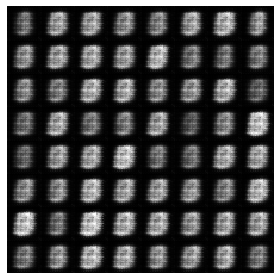

  0%|          | 1/1000 [01:11<19:57:01, 71.89s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 101/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 201/590 and on k = 1 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
On batch number 301/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 401/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 501/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
Current epoch: 2 	 Current ELBO train: -224.09127807617188
Best elbo validation -175.56918
Current elbo validation -175.56918
Saved samples to ./pics/mnist_epoch_1_K_1_N_5_amortize_False.png


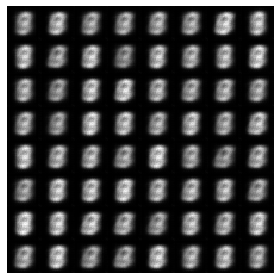

  0%|          | 2/1000 [02:23<19:56:23, 71.93s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 101/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 201/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 301/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 401/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 501/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
Current epoch: 3 	 Current ELBO train: -221.86029052734375
Best elbo validation -167.59062
Current elbo validation -167.59062
Saved samples to ./pics/mnist_epoch_2_K_1_N_5_amortize_False.png


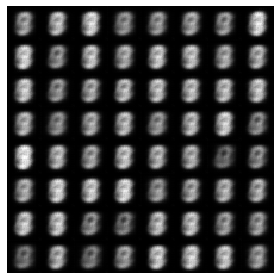

  0%|          | 3/1000 [03:36<19:59:05, 72.16s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 101/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 201/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 301/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 401/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 501/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
Current epoch: 4 	 Current ELBO train: -215.02517700195312
Best elbo validation -158.53575
Current elbo validation -158.53575
Saved samples to ./pics/mnist_epoch_3_K_1_N_5_amortize_False.png


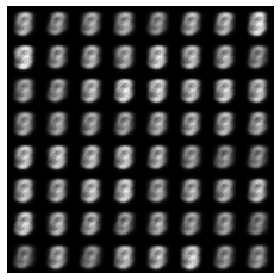

  0%|          | 4/1000 [04:49<20:00:36, 72.33s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 101/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 201/590 and on k = 1 we have for  0: 0.41999999061226845 and for +1: 0.5799999870359898
On batch number 301/590 and on k = 1 we have for  0: 0.40999999083578587 and for +1: 0.5899999868124723
On batch number 401/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 501/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
Current epoch: 5 	 Current ELBO train: -225.45286560058594
Best elbo validation -150.88228
Current elbo validation -150.88228
Saved samples to ./pics/mnist_epoch_4_K_1_N_5_amortize_False.png


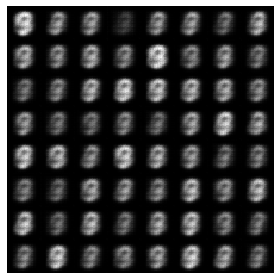

  0%|          | 5/1000 [06:02<20:01:16, 72.44s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 101/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 201/590 and on k = 1 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
On batch number 301/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 401/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 501/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
Current epoch: 6 	 Current ELBO train: -204.15296936035156
Best elbo validation -150.88228
Current elbo validation -151.29753
Saved samples to ./pics/mnist_epoch_5_K_1_N_5_amortize_False.png


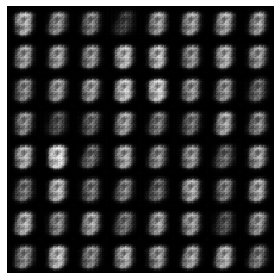

  1%|          | 6/1000 [07:14<20:01:19, 72.51s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 101/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 201/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 301/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 401/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 501/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
Current epoch: 7 	 Current ELBO train: -219.6650390625
Best elbo validation -150.88228
Current elbo validation -159.59634
Saved samples to ./pics/mnist_epoch_6_K_1_N_5_amortize_False.png


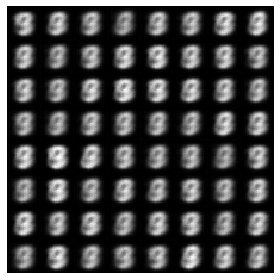

  1%|          | 7/1000 [08:27<20:00:56, 72.56s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 101/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 201/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 301/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 401/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 501/590 and on k = 1 we have for  0: 0.41999999061226845 and for +1: 0.5799999870359898
Current epoch: 8 	 Current ELBO train: -211.78977966308594
Best elbo validation -150.88228
Current elbo validation -156.75891
Saved samples to ./pics/mnist_epoch_7_K_1_N_5_amortize_False.png


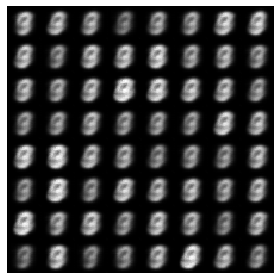

  1%|          | 8/1000 [09:40<20:00:25, 72.61s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5999999865889549 and for +1: 0.3999999910593033
On batch number 101/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 201/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 301/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 401/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 501/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
Current epoch: 9 	 Current ELBO train: -206.693359375
Best elbo validation -150.88228
Current elbo validation -154.98735
Saved samples to ./pics/mnist_epoch_8_K_1_N_5_amortize_False.png


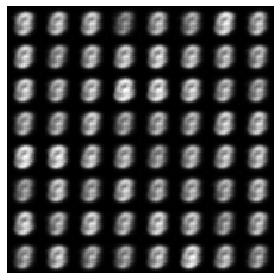

  1%|          | 9/1000 [10:52<20:00:17, 72.67s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 101/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 201/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 301/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 401/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 501/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
Current epoch: 10 	 Current ELBO train: -216.45574951171875
Best elbo validation -147.57169
Current elbo validation -147.57169
Saved samples to ./pics/mnist_epoch_9_K_1_N_5_amortize_False.png


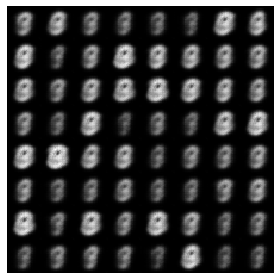

  1%|          | 10/1000 [12:05<20:00:39, 72.77s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 101/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 201/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 301/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 401/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 501/590 and on k = 1 we have for  0: 0.3999999910593033 and for +1: 0.5999999865889549
Current epoch: 11 	 Current ELBO train: -204.2566680908203
Best elbo validation -147.57169
Current elbo validation -150.24413
Saved samples to ./pics/mnist_epoch_10_K_1_N_5_amortize_False.png


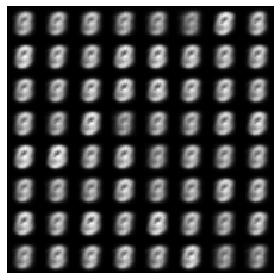

  1%|          | 11/1000 [13:18<19:59:06, 72.75s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 101/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 201/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 301/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 401/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 501/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
Current epoch: 12 	 Current ELBO train: -209.6961212158203
Best elbo validation -147.57169
Current elbo validation -154.4548
Saved samples to ./pics/mnist_epoch_11_K_1_N_5_amortize_False.png


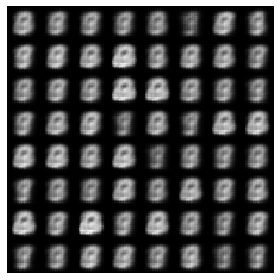

  1%|          | 12/1000 [14:31<19:57:45, 72.74s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.40999999083578587 and for +1: 0.5899999868124723
On batch number 101/590 and on k = 1 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
On batch number 201/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 301/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 401/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 501/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
Current epoch: 13 	 Current ELBO train: -200.09353637695312
Best elbo validation -143.64859
Current elbo validation -143.64859
Saved samples to ./pics/mnist_epoch_12_K_1_N_5_amortize_False.png


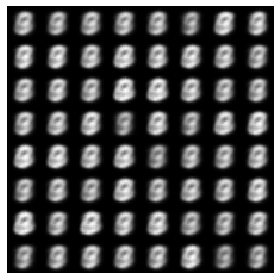

  1%|▏         | 13/1000 [15:44<19:56:23, 72.73s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 101/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 201/590 and on k = 1 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
On batch number 301/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 401/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 501/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
Current epoch: 14 	 Current ELBO train: -210.05245971679688
Best elbo validation -143.64859
Current elbo validation -151.287
Saved samples to ./pics/mnist_epoch_13_K_1_N_5_amortize_False.png


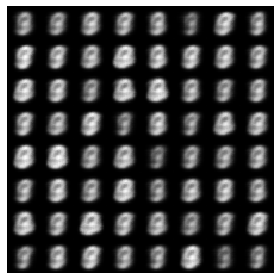

  1%|▏         | 14/1000 [16:56<19:54:54, 72.71s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 101/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 201/590 and on k = 1 we have for  0: 0.3999999910593033 and for +1: 0.5999999865889549
On batch number 301/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 401/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 501/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
Current epoch: 15 	 Current ELBO train: -202.7765350341797
Best elbo validation -143.64859
Current elbo validation -143.9281
Saved samples to ./pics/mnist_epoch_14_K_1_N_5_amortize_False.png


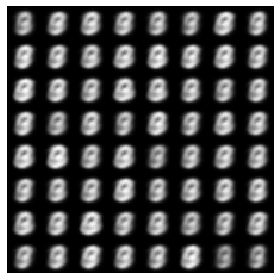

  2%|▏         | 15/1000 [18:09<19:53:54, 72.73s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.3899999912828207 and for +1: 0.6099999863654375
On batch number 101/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 201/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 301/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 401/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 501/590 and on k = 1 we have for  0: 0.3999999910593033 and for +1: 0.5999999865889549
Current epoch: 16 	 Current ELBO train: -204.12786865234375
Best elbo validation -139.35425
Current elbo validation -139.35425
Saved samples to ./pics/mnist_epoch_15_K_1_N_5_amortize_False.png


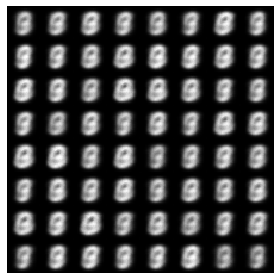

  2%|▏         | 16/1000 [19:22<19:52:42, 72.73s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 101/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 201/590 and on k = 1 we have for  0: 0.40999999083578587 and for +1: 0.5899999868124723
On batch number 301/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 401/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 501/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
Current epoch: 17 	 Current ELBO train: -218.90109252929688
Best elbo validation -139.35425
Current elbo validation -147.92392
Saved samples to ./pics/mnist_epoch_16_K_1_N_5_amortize_False.png


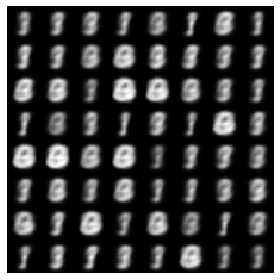

  2%|▏         | 17/1000 [20:34<19:51:21, 72.72s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 101/590 and on k = 1 we have for  0: 0.6499999854713678 and for +1: 0.3499999921768904
On batch number 201/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 301/590 and on k = 1 we have for  0: 0.5999999865889549 and for +1: 0.3999999910593033
On batch number 401/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 501/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
Current epoch: 18 	 Current ELBO train: -208.49459838867188
Best elbo validation -139.35425
Current elbo validation -147.75015
Saved samples to ./pics/mnist_epoch_17_K_1_N_5_amortize_False.png


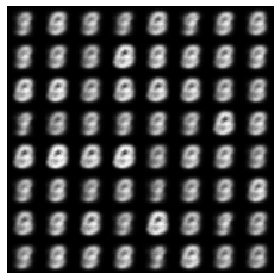

  2%|▏         | 18/1000 [21:47<19:50:06, 72.72s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 101/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 201/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 301/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 401/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 501/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
Current epoch: 19 	 Current ELBO train: -200.97662353515625
Best elbo validation -139.35425
Current elbo validation -146.35516
Saved samples to ./pics/mnist_epoch_18_K_1_N_5_amortize_False.png


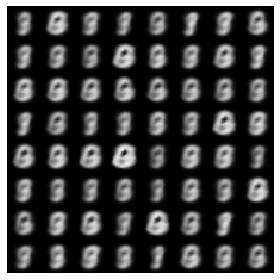

  2%|▏         | 19/1000 [23:00<19:49:31, 72.75s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5999999865889549 and for +1: 0.3999999910593033
On batch number 101/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 201/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 301/590 and on k = 1 we have for  0: 0.6399999856948853 and for +1: 0.35999999195337296
On batch number 401/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 501/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
Current epoch: 20 	 Current ELBO train: -196.53163146972656
Best elbo validation -139.35425
Current elbo validation -139.89027
Saved samples to ./pics/mnist_epoch_19_K_1_N_5_amortize_False.png


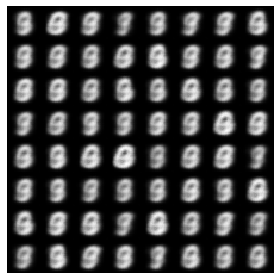

  2%|▏         | 20/1000 [24:13<19:48:38, 72.77s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.40999999083578587 and for +1: 0.5899999868124723
On batch number 101/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 201/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 301/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 401/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 501/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
Current epoch: 21 	 Current ELBO train: -193.73361206054688
Best elbo validation -139.35425
Current elbo validation -141.01288
Saved samples to ./pics/mnist_epoch_20_K_1_N_5_amortize_False.png


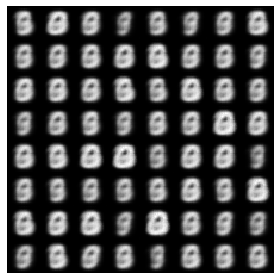

  2%|▏         | 21/1000 [25:25<19:47:01, 72.75s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 101/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 201/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 301/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 401/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 501/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
Current epoch: 22 	 Current ELBO train: -192.05638122558594
Best elbo validation -130.98582
Current elbo validation -130.98582
Saved samples to ./pics/mnist_epoch_21_K_1_N_5_amortize_False.png


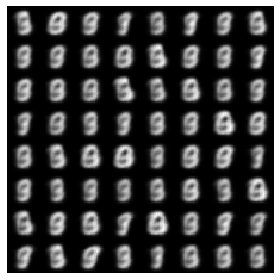

  2%|▏         | 22/1000 [26:38<19:45:33, 72.73s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 101/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 201/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 301/590 and on k = 1 we have for  0: 0.41999999061226845 and for +1: 0.5799999870359898
On batch number 401/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 501/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
Current epoch: 23 	 Current ELBO train: -195.27105712890625
Best elbo validation -130.98582
Current elbo validation -137.23978
Saved samples to ./pics/mnist_epoch_22_K_1_N_5_amortize_False.png


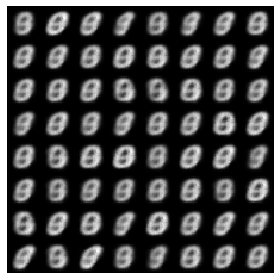

  2%|▏         | 23/1000 [27:51<19:44:06, 72.72s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 101/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 201/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 301/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 401/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 501/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
Current epoch: 24 	 Current ELBO train: -196.5636749267578
Best elbo validation -130.98582
Current elbo validation -136.35153
Saved samples to ./pics/mnist_epoch_23_K_1_N_5_amortize_False.png


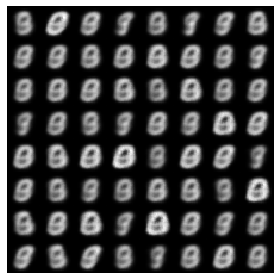

  2%|▏         | 24/1000 [29:04<19:42:49, 72.71s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 101/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 201/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 301/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 401/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 501/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
Current epoch: 25 	 Current ELBO train: -187.02777099609375
Best elbo validation -130.98582
Current elbo validation -131.45528
Saved samples to ./pics/mnist_epoch_24_K_1_N_5_amortize_False.png


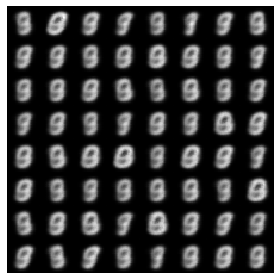

  2%|▎         | 25/1000 [30:16<19:41:23, 72.70s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 101/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 201/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 301/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 401/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 501/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
Current epoch: 26 	 Current ELBO train: -191.55210876464844
Best elbo validation -130.98582
Current elbo validation -136.03444
Saved samples to ./pics/mnist_epoch_25_K_1_N_5_amortize_False.png


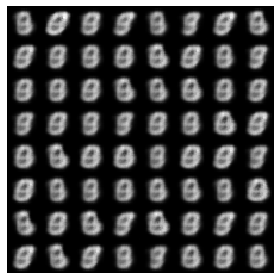

  3%|▎         | 26/1000 [31:29<19:40:10, 72.70s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 101/590 and on k = 1 we have for  0: 0.5999999865889549 and for +1: 0.3999999910593033
On batch number 201/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 301/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 401/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 501/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
Current epoch: 27 	 Current ELBO train: -199.39671325683594
Best elbo validation -129.4352
Current elbo validation -129.4352
Saved samples to ./pics/mnist_epoch_26_K_1_N_5_amortize_False.png


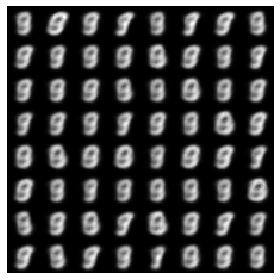

  3%|▎         | 27/1000 [32:42<19:39:02, 72.71s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 101/590 and on k = 1 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
On batch number 201/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 301/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 401/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 501/590 and on k = 1 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
Current epoch: 28 	 Current ELBO train: -209.71620178222656
Best elbo validation -129.4352
Current elbo validation -146.16876
Saved samples to ./pics/mnist_epoch_27_K_1_N_5_amortize_False.png


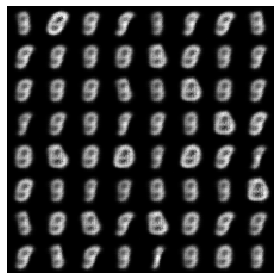

  3%|▎         | 28/1000 [33:54<19:37:43, 72.70s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 101/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 201/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 301/590 and on k = 1 we have for  0: 0.3999999910593033 and for +1: 0.5999999865889549
On batch number 401/590 and on k = 1 we have for  0: 0.40999999083578587 and for +1: 0.5899999868124723
On batch number 501/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
Current epoch: 29 	 Current ELBO train: -179.4811248779297
Best elbo validation -129.4352
Current elbo validation -130.54369
Saved samples to ./pics/mnist_epoch_28_K_1_N_5_amortize_False.png


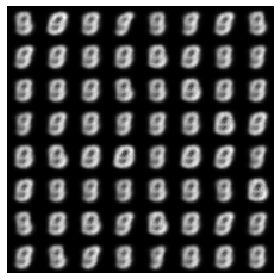

  3%|▎         | 29/1000 [35:07<19:37:08, 72.74s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 101/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 201/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 301/590 and on k = 1 we have for  0: 0.41999999061226845 and for +1: 0.5799999870359898
On batch number 401/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 501/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
Current epoch: 30 	 Current ELBO train: -192.4600372314453
Best elbo validation -129.4352
Current elbo validation -134.38075
Saved samples to ./pics/mnist_epoch_29_K_1_N_5_amortize_False.png


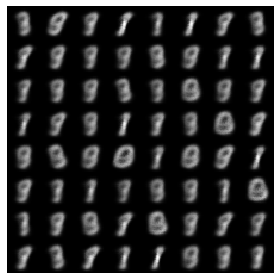

  3%|▎         | 30/1000 [36:20<19:36:11, 72.75s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 101/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 201/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 301/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 401/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 501/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
Current epoch: 31 	 Current ELBO train: -197.8764190673828
Best elbo validation -129.4352
Current elbo validation -129.90256
Saved samples to ./pics/mnist_epoch_30_K_1_N_5_amortize_False.png


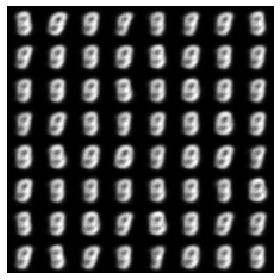

  3%|▎         | 31/1000 [37:33<19:34:35, 72.73s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5999999865889549 and for +1: 0.3999999910593033
On batch number 101/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 201/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 301/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 401/590 and on k = 1 we have for  0: 0.6099999863654375 and for +1: 0.3899999912828207
On batch number 501/590 and on k = 1 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
Current epoch: 32 	 Current ELBO train: -191.1736297607422
Best elbo validation -126.62974
Current elbo validation -126.62974
Saved samples to ./pics/mnist_epoch_31_K_1_N_5_amortize_False.png


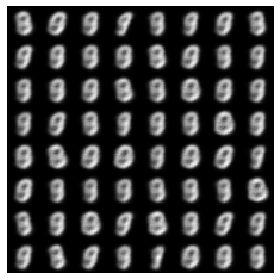

  3%|▎         | 32/1000 [38:46<19:34:22, 72.79s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 101/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 201/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 301/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 401/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 501/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
Current epoch: 33 	 Current ELBO train: -191.2853546142578
Best elbo validation -126.62974
Current elbo validation -129.80899
Saved samples to ./pics/mnist_epoch_32_K_1_N_5_amortize_False.png


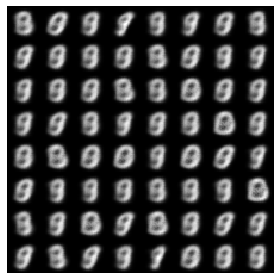

  3%|▎         | 33/1000 [39:58<19:33:01, 72.78s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
On batch number 101/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 201/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 301/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 401/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 501/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
Current epoch: 34 	 Current ELBO train: -180.16702270507812
Best elbo validation -126.62974
Current elbo validation -130.60521
Saved samples to ./pics/mnist_epoch_33_K_1_N_5_amortize_False.png


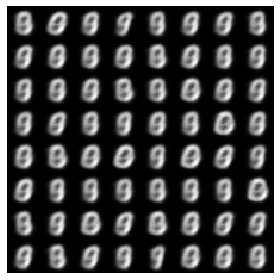

  3%|▎         | 34/1000 [41:11<19:31:20, 72.75s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.40999999083578587 and for +1: 0.5899999868124723
On batch number 101/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 201/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 301/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 401/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 501/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
Current epoch: 35 	 Current ELBO train: -178.7440643310547
Best elbo validation -126.225075
Current elbo validation -126.225075
Saved samples to ./pics/mnist_epoch_34_K_1_N_5_amortize_False.png


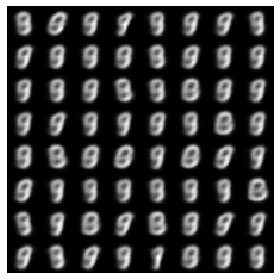

  4%|▎         | 35/1000 [42:24<19:29:45, 72.73s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 101/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 201/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 301/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 401/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 501/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
Current epoch: 36 	 Current ELBO train: -184.11949157714844
Best elbo validation -125.804565
Current elbo validation -125.804565
Saved samples to ./pics/mnist_epoch_35_K_1_N_5_amortize_False.png


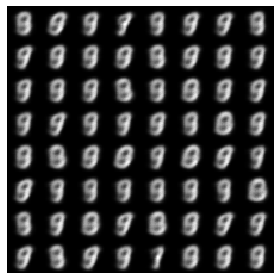

  4%|▎         | 36/1000 [43:36<19:28:21, 72.72s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 101/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 201/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 301/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 401/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 501/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
Current epoch: 37 	 Current ELBO train: -180.466552734375
Best elbo validation -125.804565
Current elbo validation -126.54842
Saved samples to ./pics/mnist_epoch_36_K_1_N_5_amortize_False.png


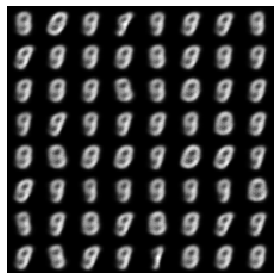

  4%|▎         | 37/1000 [44:49<19:26:52, 72.70s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 101/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 201/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 301/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 401/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 501/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
Current epoch: 38 	 Current ELBO train: -177.08399963378906
Best elbo validation -125.804565
Current elbo validation -127.86271
Saved samples to ./pics/mnist_epoch_37_K_1_N_5_amortize_False.png


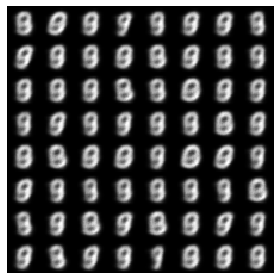

  4%|▍         | 38/1000 [46:02<19:25:46, 72.71s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 101/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 201/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 301/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 401/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 501/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
Current epoch: 39 	 Current ELBO train: -180.4042510986328
Best elbo validation -124.18966
Current elbo validation -124.18966
Saved samples to ./pics/mnist_epoch_38_K_1_N_5_amortize_False.png


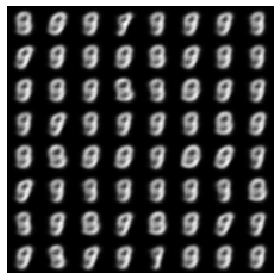

  4%|▍         | 39/1000 [47:15<19:25:06, 72.74s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 101/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 201/590 and on k = 1 we have for  0: 0.41999999061226845 and for +1: 0.5799999870359898
On batch number 301/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 401/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 501/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
Current epoch: 40 	 Current ELBO train: -185.65921020507812
Best elbo validation -124.18966
Current elbo validation -126.39199
Saved samples to ./pics/mnist_epoch_39_K_1_N_5_amortize_False.png


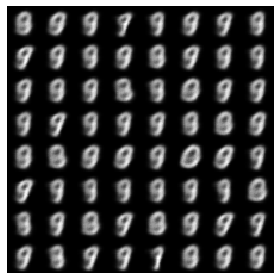

  4%|▍         | 40/1000 [48:27<19:24:05, 72.76s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 101/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 201/590 and on k = 1 we have for  0: 0.3799999915063381 and for +1: 0.6199999861419201
On batch number 301/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 401/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 501/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
Current epoch: 41 	 Current ELBO train: -182.6700897216797
Best elbo validation -123.27619
Current elbo validation -123.27619
Saved samples to ./pics/mnist_epoch_40_K_1_N_5_amortize_False.png


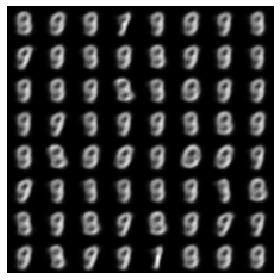

  4%|▍         | 41/1000 [49:40<19:22:38, 72.74s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 101/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 201/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 301/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 401/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 501/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
Current epoch: 42 	 Current ELBO train: -181.73960876464844
Best elbo validation -123.27619
Current elbo validation -124.88228
Saved samples to ./pics/mnist_epoch_41_K_1_N_5_amortize_False.png


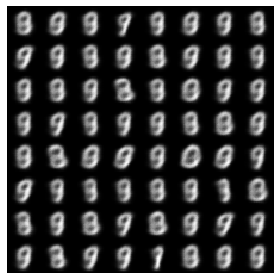

  4%|▍         | 42/1000 [50:53<19:21:04, 72.72s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 101/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 201/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 301/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 401/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 501/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
Current epoch: 43 	 Current ELBO train: -174.49855041503906
Best elbo validation -123.27619
Current elbo validation -124.56782
Saved samples to ./pics/mnist_epoch_42_K_1_N_5_amortize_False.png


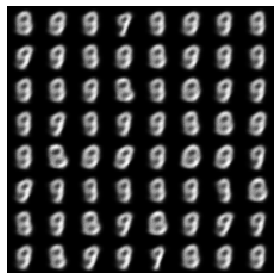

  4%|▍         | 43/1000 [52:05<19:19:38, 72.70s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.40999999083578587 and for +1: 0.5899999868124723
On batch number 101/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 201/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 301/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 401/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 501/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
Current epoch: 44 	 Current ELBO train: -181.0617218017578
Best elbo validation -121.817154
Current elbo validation -121.817154
Saved samples to ./pics/mnist_epoch_43_K_1_N_5_amortize_False.png


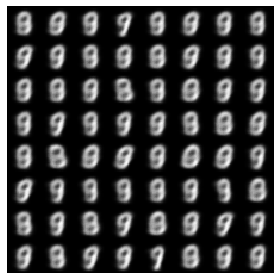

  4%|▍         | 44/1000 [53:18<19:18:28, 72.71s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 101/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 201/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 301/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 401/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 501/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
Current epoch: 45 	 Current ELBO train: -177.02464294433594
Best elbo validation -121.56692
Current elbo validation -121.56692
Saved samples to ./pics/mnist_epoch_44_K_1_N_5_amortize_False.png


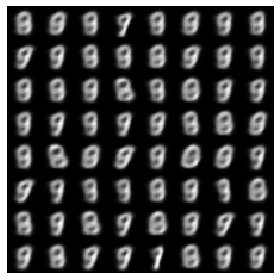

  4%|▍         | 45/1000 [54:31<19:17:08, 72.70s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 101/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 201/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 301/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 401/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 501/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
Current epoch: 46 	 Current ELBO train: -180.74951171875
Best elbo validation -119.64875
Current elbo validation -119.64875
Saved samples to ./pics/mnist_epoch_45_K_1_N_5_amortize_False.png


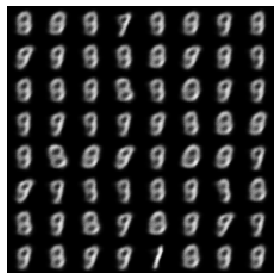

  5%|▍         | 46/1000 [55:43<19:15:51, 72.70s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 101/590 and on k = 1 we have for  0: 0.41999999061226845 and for +1: 0.5799999870359898
On batch number 201/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 301/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 401/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 501/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
Current epoch: 47 	 Current ELBO train: -176.65997314453125
Best elbo validation -115.51801
Current elbo validation -115.51801
Saved samples to ./pics/mnist_epoch_46_K_1_N_5_amortize_False.png


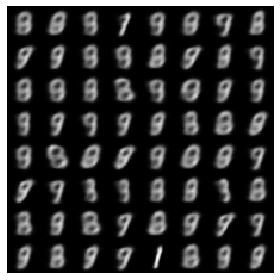

  5%|▍         | 47/1000 [56:56<19:15:32, 72.75s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 101/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 201/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 301/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 401/590 and on k = 1 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
On batch number 501/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
Current epoch: 48 	 Current ELBO train: -163.44586181640625
Best elbo validation -110.83908
Current elbo validation -110.83908
Saved samples to ./pics/mnist_epoch_47_K_1_N_5_amortize_False.png


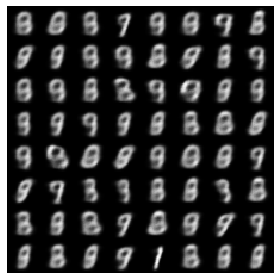

  5%|▍         | 48/1000 [58:09<19:14:04, 72.74s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 101/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 201/590 and on k = 1 we have for  0: 0.3999999910593033 and for +1: 0.5999999865889549
On batch number 301/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 401/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 501/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
Current epoch: 49 	 Current ELBO train: -162.73635864257812
Best elbo validation -108.97978
Current elbo validation -108.97978
Saved samples to ./pics/mnist_epoch_48_K_1_N_5_amortize_False.png


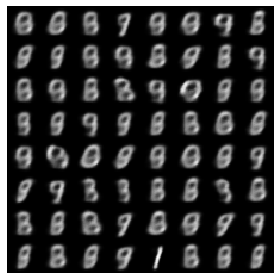

  5%|▍         | 49/1000 [59:22<19:13:15, 72.76s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 101/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 201/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 301/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 401/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 501/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
Current epoch: 50 	 Current ELBO train: -157.59429931640625
Best elbo validation -107.73309
Current elbo validation -107.73309
Saved samples to ./pics/mnist_epoch_49_K_1_N_5_amortize_False.png


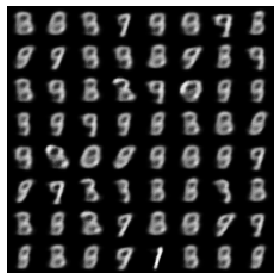

  5%|▌         | 50/1000 [1:00:35<19:12:17, 72.78s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 101/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 201/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 301/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 401/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 501/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
Current epoch: 51 	 Current ELBO train: -173.3011474609375
Best elbo validation -106.77969
Current elbo validation -106.77969
Saved samples to ./pics/mnist_epoch_50_K_1_N_5_amortize_False.png


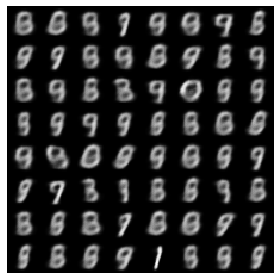

  5%|▌         | 51/1000 [1:01:47<19:10:42, 72.75s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 101/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 201/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 301/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 401/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 501/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
Current epoch: 52 	 Current ELBO train: -163.88265991210938
Best elbo validation -106.27592
Current elbo validation -106.27592
Saved samples to ./pics/mnist_epoch_51_K_1_N_5_amortize_False.png


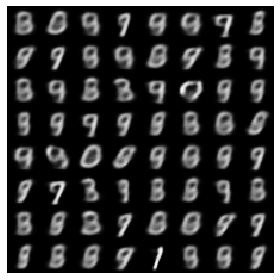

  5%|▌         | 52/1000 [1:03:00<19:09:20, 72.74s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 101/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 201/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 301/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 401/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 501/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
Current epoch: 53 	 Current ELBO train: -160.81179809570312
Best elbo validation -102.327644
Current elbo validation -102.327644
Saved samples to ./pics/mnist_epoch_52_K_1_N_5_amortize_False.png


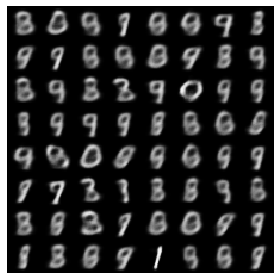

  5%|▌         | 53/1000 [1:04:13<19:07:57, 72.73s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 101/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 201/590 and on k = 1 we have for  0: 0.6099999863654375 and for +1: 0.3899999912828207
On batch number 301/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 401/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 501/590 and on k = 1 we have for  0: 0.41999999061226845 and for +1: 0.5799999870359898
Current epoch: 54 	 Current ELBO train: -153.15248107910156
Best elbo validation -98.871056
Current elbo validation -98.871056
Saved samples to ./pics/mnist_epoch_53_K_1_N_5_amortize_False.png


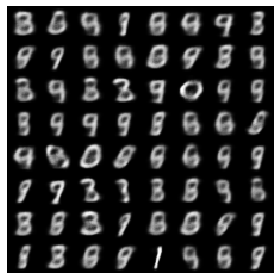

  5%|▌         | 54/1000 [1:05:26<19:06:30, 72.72s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 101/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 201/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 301/590 and on k = 1 we have for  0: 0.41999999061226845 and for +1: 0.5799999870359898
On batch number 401/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 501/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
Current epoch: 55 	 Current ELBO train: -148.6106414794922
Best elbo validation -98.76688
Current elbo validation -98.76688
Saved samples to ./pics/mnist_epoch_54_K_1_N_5_amortize_False.png


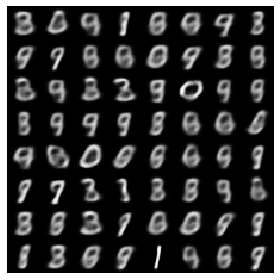

  6%|▌         | 55/1000 [1:06:38<19:05:08, 72.71s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 101/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 201/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 301/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 401/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 501/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
Current epoch: 56 	 Current ELBO train: -157.0581817626953
Best elbo validation -95.45441
Current elbo validation -95.45441
Saved samples to ./pics/mnist_epoch_55_K_1_N_5_amortize_False.png


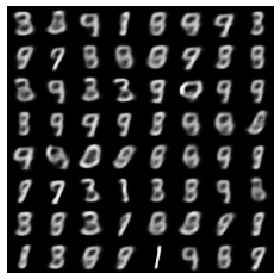

  6%|▌         | 56/1000 [1:07:51<19:03:46, 72.70s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 101/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 201/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 301/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 401/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 501/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
Current epoch: 57 	 Current ELBO train: -157.9035186767578
Best elbo validation -95.45441
Current elbo validation -95.9741
Saved samples to ./pics/mnist_epoch_56_K_1_N_5_amortize_False.png


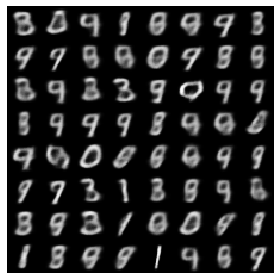

  6%|▌         | 57/1000 [1:09:04<19:02:23, 72.69s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 101/590 and on k = 1 we have for  0: 0.41999999061226845 and for +1: 0.5799999870359898
On batch number 201/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 301/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 401/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 501/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
Current epoch: 58 	 Current ELBO train: -152.7792510986328
Best elbo validation -93.66609
Current elbo validation -93.66609
Saved samples to ./pics/mnist_epoch_57_K_1_N_5_amortize_False.png


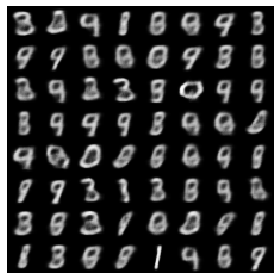

  6%|▌         | 58/1000 [1:10:16<19:01:13, 72.69s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 101/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 201/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 301/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 401/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 501/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
Current epoch: 59 	 Current ELBO train: -155.59092712402344
Best elbo validation -92.71237
Current elbo validation -92.71237
Saved samples to ./pics/mnist_epoch_58_K_1_N_5_amortize_False.png


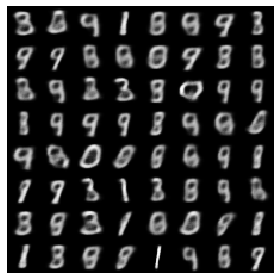

  6%|▌         | 59/1000 [1:11:29<19:00:33, 72.72s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 101/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 201/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 301/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 401/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 501/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
Current epoch: 60 	 Current ELBO train: -157.803466796875
Best elbo validation -91.27769
Current elbo validation -91.27769
Saved samples to ./pics/mnist_epoch_59_K_1_N_5_amortize_False.png


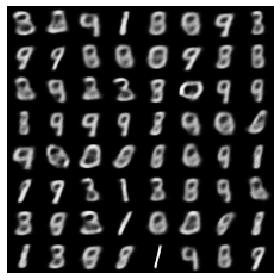

  6%|▌         | 60/1000 [1:12:42<18:59:42, 72.75s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 101/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 201/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 301/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 401/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 501/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
Current epoch: 61 	 Current ELBO train: -145.09361267089844
Best elbo validation -89.90908
Current elbo validation -89.90908
Saved samples to ./pics/mnist_epoch_60_K_1_N_5_amortize_False.png


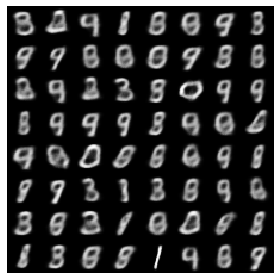

  6%|▌         | 61/1000 [1:13:55<18:58:08, 72.72s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 101/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 201/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 301/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 401/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 501/590 and on k = 1 we have for  0: 0.41999999061226845 and for +1: 0.5799999870359898
Current epoch: 62 	 Current ELBO train: -143.03515625
Best elbo validation -88.412346
Current elbo validation -88.412346
Saved samples to ./pics/mnist_epoch_61_K_1_N_5_amortize_False.png


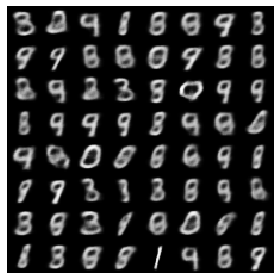

  6%|▌         | 62/1000 [1:15:07<18:56:41, 72.71s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 101/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 201/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 301/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 401/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 501/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
Current epoch: 63 	 Current ELBO train: -144.82615661621094
Best elbo validation -88.09151
Current elbo validation -88.09151
Saved samples to ./pics/mnist_epoch_62_K_1_N_5_amortize_False.png


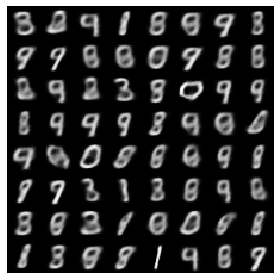

  6%|▋         | 63/1000 [1:16:20<18:55:17, 72.70s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 101/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 201/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 301/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 401/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 501/590 and on k = 1 we have for  0: 0.3799999915063381 and for +1: 0.6199999861419201
Current epoch: 64 	 Current ELBO train: -143.0909881591797
Best elbo validation -88.09151
Current elbo validation -88.62937
Saved samples to ./pics/mnist_epoch_63_K_1_N_5_amortize_False.png


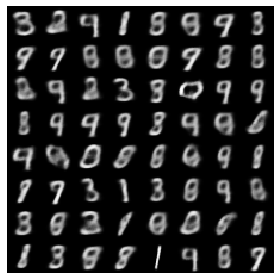

  6%|▋         | 64/1000 [1:17:33<18:53:53, 72.69s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 101/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 201/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 301/590 and on k = 1 we have for  0: 0.6099999863654375 and for +1: 0.3899999912828207
On batch number 401/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 501/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
Current epoch: 65 	 Current ELBO train: -143.0465850830078
Best elbo validation -84.852295
Current elbo validation -84.852295
Saved samples to ./pics/mnist_epoch_64_K_1_N_5_amortize_False.png


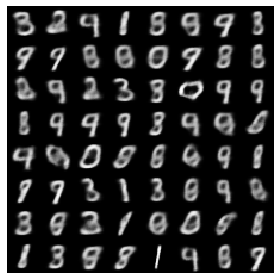

  6%|▋         | 65/1000 [1:18:45<18:52:41, 72.69s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 101/590 and on k = 1 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
On batch number 201/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 301/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 401/590 and on k = 1 we have for  0: 0.3999999910593033 and for +1: 0.5999999865889549
On batch number 501/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
Current epoch: 66 	 Current ELBO train: -143.81935119628906
Best elbo validation -83.714966
Current elbo validation -83.714966
Saved samples to ./pics/mnist_epoch_65_K_1_N_5_amortize_False.png


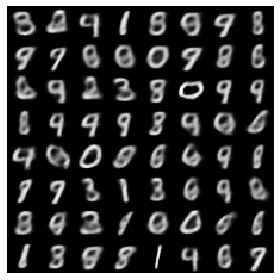

  7%|▋         | 66/1000 [1:19:58<18:51:39, 72.70s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 101/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 201/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 301/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 401/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 501/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
Current epoch: 67 	 Current ELBO train: -141.548095703125
Best elbo validation -82.689125
Current elbo validation -82.689125
Saved samples to ./pics/mnist_epoch_66_K_1_N_5_amortize_False.png


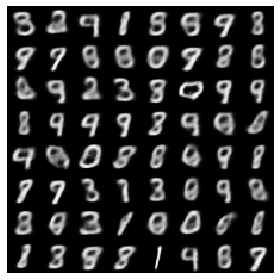

  7%|▋         | 67/1000 [1:21:11<18:50:21, 72.69s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
On batch number 101/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 201/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 301/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 401/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 501/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
Current epoch: 68 	 Current ELBO train: -136.918701171875
Best elbo validation -80.90796
Current elbo validation -80.90796
Saved samples to ./pics/mnist_epoch_67_K_1_N_5_amortize_False.png


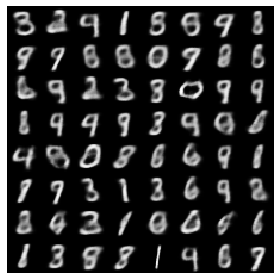

  7%|▋         | 68/1000 [1:22:23<18:49:06, 72.69s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 101/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 201/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 301/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 401/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 501/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
Current epoch: 69 	 Current ELBO train: -136.35182189941406
Best elbo validation -78.861176
Current elbo validation -78.861176
Saved samples to ./pics/mnist_epoch_68_K_1_N_5_amortize_False.png


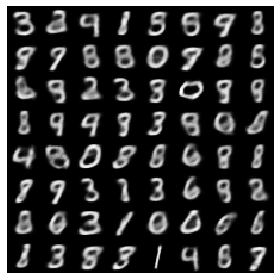

  7%|▋         | 69/1000 [1:23:36<18:48:28, 72.73s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 101/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 201/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 301/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 401/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 501/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
Current epoch: 70 	 Current ELBO train: -137.70852661132812
Best elbo validation -77.06454
Current elbo validation -77.06454
Saved samples to ./pics/mnist_epoch_69_K_1_N_5_amortize_False.png


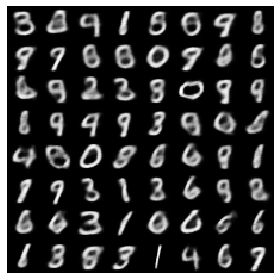

  7%|▋         | 70/1000 [1:24:49<18:47:39, 72.75s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 101/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 201/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 301/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 401/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 501/590 and on k = 1 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
Current epoch: 71 	 Current ELBO train: -129.73983764648438
Best elbo validation -77.06454
Current elbo validation -80.99651
Saved samples to ./pics/mnist_epoch_70_K_1_N_5_amortize_False.png


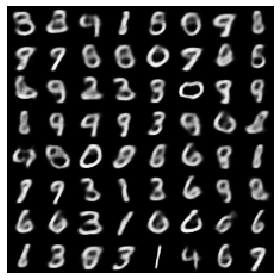

  7%|▋         | 71/1000 [1:26:02<18:45:59, 72.72s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 101/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 201/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 301/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 401/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 501/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
Current epoch: 72 	 Current ELBO train: -135.32113647460938
Best elbo validation -74.207405
Current elbo validation -74.207405
Saved samples to ./pics/mnist_epoch_71_K_1_N_5_amortize_False.png


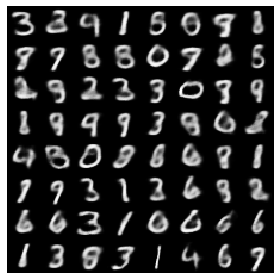

  7%|▋         | 72/1000 [1:27:14<18:44:36, 72.71s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 101/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 201/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 301/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 401/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 501/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
Current epoch: 73 	 Current ELBO train: -130.868896484375
Best elbo validation -72.62999
Current elbo validation -72.62999
Saved samples to ./pics/mnist_epoch_72_K_1_N_5_amortize_False.png


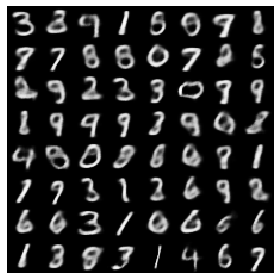

  7%|▋         | 73/1000 [1:28:27<18:43:12, 72.70s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 101/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 201/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 301/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 401/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 501/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
Current epoch: 74 	 Current ELBO train: -133.2945556640625
Best elbo validation -72.62999
Current elbo validation -75.52721
Saved samples to ./pics/mnist_epoch_73_K_1_N_5_amortize_False.png


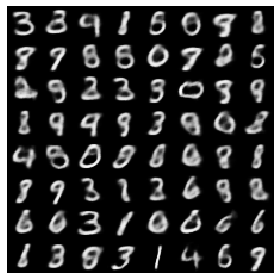

  7%|▋         | 74/1000 [1:29:40<18:41:48, 72.69s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 101/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 201/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 301/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 401/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 501/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
Current epoch: 75 	 Current ELBO train: -131.6240234375
Best elbo validation -72.59256
Current elbo validation -72.59256
Saved samples to ./pics/mnist_epoch_74_K_1_N_5_amortize_False.png


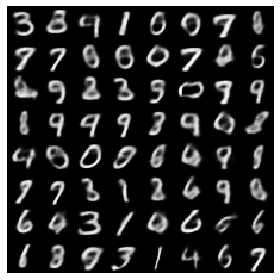

  8%|▊         | 75/1000 [1:30:52<18:40:37, 72.69s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 101/590 and on k = 1 we have for  0: 0.3899999912828207 and for +1: 0.6099999863654375
On batch number 201/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 301/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 401/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 501/590 and on k = 1 we have for  0: 0.41999999061226845 and for +1: 0.5799999870359898
Current epoch: 76 	 Current ELBO train: -131.07656860351562
Best elbo validation -72.59256
Current elbo validation -76.3088
Saved samples to ./pics/mnist_epoch_75_K_1_N_5_amortize_False.png


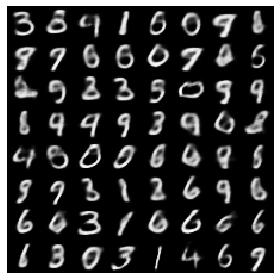

  8%|▊         | 76/1000 [1:32:05<18:39:18, 72.68s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 101/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 201/590 and on k = 1 we have for  0: 0.41999999061226845 and for +1: 0.5799999870359898
On batch number 301/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 401/590 and on k = 1 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
On batch number 501/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
Current epoch: 77 	 Current ELBO train: -127.39786529541016
Best elbo validation -72.59256
Current elbo validation -72.66354
Saved samples to ./pics/mnist_epoch_76_K_1_N_5_amortize_False.png


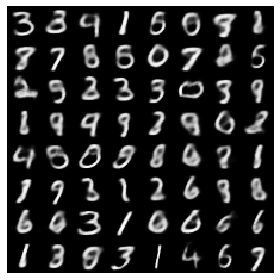

  8%|▊         | 77/1000 [1:33:18<18:37:59, 72.68s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 101/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 201/590 and on k = 1 we have for  0: 0.3799999915063381 and for +1: 0.6199999861419201
On batch number 301/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 401/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 501/590 and on k = 1 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
Current epoch: 78 	 Current ELBO train: -129.49986267089844
Best elbo validation -71.02359
Current elbo validation -71.02359
Saved samples to ./pics/mnist_epoch_77_K_1_N_5_amortize_False.png


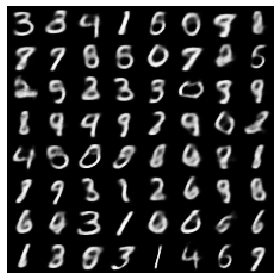

  8%|▊         | 78/1000 [1:34:31<18:39:03, 72.82s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
On batch number 101/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 201/590 and on k = 1 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
On batch number 301/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 401/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 501/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
Current epoch: 79 	 Current ELBO train: -125.32048797607422
Best elbo validation -71.02359
Current elbo validation -71.70769
Saved samples to ./pics/mnist_epoch_78_K_1_N_5_amortize_False.png


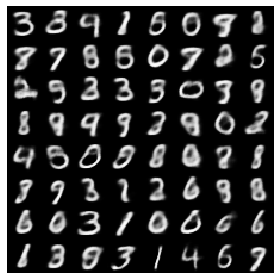

  8%|▊         | 79/1000 [1:35:44<18:37:46, 72.82s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 101/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 201/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 301/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 401/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 501/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
Current epoch: 80 	 Current ELBO train: -120.76712799072266
Best elbo validation -71.02359
Current elbo validation -73.49135
Saved samples to ./pics/mnist_epoch_79_K_1_N_5_amortize_False.png


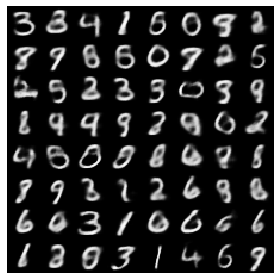

  8%|▊         | 80/1000 [1:36:56<18:36:31, 72.82s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 101/590 and on k = 1 we have for  0: 0.6199999861419201 and for +1: 0.3799999915063381


In [ ]:
print_info_ = 1
torch_log_2 = torch.tensor(np.log(2.), device=args.device, dtype=args.torchType)

best_elbo = -float("inf")
current_elbo_val = -float("inf")

current_tolerance = 0
# with torch.autograd.detect_anomaly():
for ep in tqdm(range(args.num_epoches)): # cycle over epoches
    for b_num, batch_train in enumerate(dataset.next_train_batch()): # cycle over batches
        target.decoder.train()
        plt.close()        

        mu, sigma = encoder(batch_train) # sample mu and sigma from encoder
        u = args.std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
        z = mu + sigma * u # reperametrization trick
        sum_log_sigma = torch.sum(torch.log(sigma), 1)
        if ep < args.vanilla_vae_epoches:
            log_p = target.get_logdensity(z=z, x=batch_train)
            log_m = args.std_normal.log_prob(u).sum(1) - sum_log_sigma
            elbo_full = torch.mean(log_p - log_m)
            (-elbo_full).backward()
            optimizer_vanilla.step()
            optimizer_vanilla.zero_grad()
            if b_num == (args.train_batch_size - 1):
                args.train_batch_size = batch_size
                dataset = Dataset(args, device=args.device)
        else:
            target.train()
            p_old = args.std_normal.sample(z.shape)
            cond_vectors = [args.std_normal.sample(p_old.shape) for k in range(args.K)]

            sum_log_alpha = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
            sum_log_jacobian = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
            p = p_old
            if args.learnable_reverse:
                all_directions = torch.tensor([], device=args.device)
            else:
                all_directions = None
            for k in range(args.K):
                # sample alpha - transition probabilities 
                if args.amortize:
#                     pdb.set_trace()
                    z, p, log_jac, current_log_alphas, directions, _ = transitions.make_transition(q_old=z, x=batch_train,
                                                        p_old=p, k=cond_vectors[k], target_distr=target)
                else:
                    z, p, log_jac, current_log_alphas, directions, _ = transitions[k].make_transition(q_old=z, x=batch_train,
                                                                        p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
                if ep  % print_info_ == 0 and b_num % (100 * print_info_) == 0:
                    print('On batch number {}/{} and on k = {} we have for  0: {} and for +1: {}'.format(b_num + 1,
                                                                            dataset.train.shape[0] // args['train_batch_size'],
                                                                               k + 1,
                                                        (directions==0.).to(float).mean(),
                                                                        (directions==1.).to(float).mean()))
                    if args.amortize:
                        print('Stepsize {}'.format(np.exp(transitions.gamma.cpu().detach().item())))
                        print('Autoregression coeff {}'.format(torch.sigmoid(transitions.alpha_logit).cpu().detach().item()))
                if args.learnable_reverse:
                    all_directions = torch.cat([all_directions, directions.view(-1, 1)], dim=1)
                # Accumulate alphas
                sum_log_alpha = sum_log_alpha + current_log_alphas
                sum_log_jacobian = sum_log_jacobian + log_jac  # refresh log jacobian
            ##############################################
            if args.hoffman_idea:
                if args.learnable_reverse:
                    log_r = reverse_kernel(z_fin=z.detach(), mu=mu.detach(), a=all_directions)
                    log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jacobian - sum_log_sigma + sum_log_alpha
                else:
                    log_r = 0 #-args.K * torch_log_2
                    log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jacobian - sum_log_sigma # + sum_log_alpha
                log_p = target.get_logdensity(z=z, x=batch_train) + args.std_normal.log_prob(p.sum(1))
                elbo_full = log_p + log_r - log_m
#                 pdb.set_trace()
                ### Gradient of the first objective:
                target.eval()
                obj_1 = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
                (-obj_1).backward(retain_graph=True)
                optimizer_inference.step()
                optimizer_inference.zero_grad()
                optimizer.zero_grad() 
                
                ### Gradient of the second objective:
                target.train()
                log_p = target.get_logdensity(z=z.detach(), x=batch_train) + args.std_normal.log_prob(p.detach()).sum(1)
                elbo_full = log_p - log_m
                obj_2 = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
                (-obj_2).backward()
                optimizer.step()
                optimizer_inference.zero_grad()
                optimizer.zero_grad()
            ###########################################################
            else:
                elbo_full, grad_elbo = compute_loss(z_new=z, p_new=p, u=u, p_old=p_old, x=batch_train, sum_log_alpha=sum_log_alpha,
                                                    sum_log_jac=sum_log_jacobian, sum_log_sigma=sum_log_sigma, mu=mu, all_directions=all_directions)
                (-grad_elbo).backward()
            if args.clip_norm:
                torch.nn.utils.clip_grad_norm_(itertools.chain(*params), args.clip_value)
                
            if args.separate_params: # if we separate params of inference part and generation part
                optimizer_inference.step() # we always perform step for inference part
                if (ep - args.vanilla_vae_epoches) % args.train_only_inference_period > args.train_only_inference_cutoff: # but sometimes for gen
                    optimizer.step()
                optimizer.zero_grad()
                optimizer_inference.zero_grad()
            else:
                optimizer.step()
                optimizer.zero_grad()
                
    ###### validation ######
    target.decoder.eval()
#             pdb.set_trace()
    current_elbo_val = validate_vae(args=args, encoder=encoder, target=target, transitions=transitions, dataset=dataset)
    if (current_elbo_val != current_elbo_val).sum():
        print('NAN appeared!')
        raise ValueError
    if current_elbo_val > best_elbo:
        current_tolerance = 0
        best_elbo = current_elbo_val
        if not os.path.exists('./models/{}/'.format(args.data)):
            os.makedirs('./models/{}/'.format(args.data))
        torch.save(encoder,
            './models/{}/best_encoder_data_{}_K_{}_N_{}_fixtransition_{}_amortize_{}_learnreverse_{}_vanillaepoches_{}_hoffmanlike_{}_separateparams_{}_usebatchnorm_{}_decoder_{}.pt'.format(args.data,
                                    args.data, args.K, args.N, args.fix_transition_params, args.amortize, args.learnable_reverse, args.vanilla_vae_epoches,
                                                                                                args.hoffman_idea, args.separate_params, args.use_batchnorm, args.decoder))
        torch.save(target.decoder,
            './models/{}/best_decoder_data_{}_K_{}_N_{}_fixtransition_{}_amortize_{}_learnreverse_{}_vanillaepoches_{}_hoffmanlike_{}_separateparams_{}_usebatchnorm_{}_decoder_{}.pt'.format(args.data,
                                    args.data, args.K, args.N, args.fix_transition_params, args.amortize, args.learnable_reverse, args.vanilla_vae_epoches,
                                                                                                args.hoffman_idea, args.separate_params, args.use_batchnorm, args.decoder))
        torch.save(transitions,
            './models/{}/best_transitions_data_{}_K_{}_N_{}_fixtransition_{}_amortize_{}_learnreverse_{}_vanillaepoches_{}_hoffmanlike_{}_separateparams_{}_usebatchnorm_{}_decoder_{}.pt'.format(args.data,
                                    args.data, args.K, args.N, args.fix_transition_params, args.amortize, args.learnable_reverse, args.vanilla_vae_epoches,
                                                                                                args.hoffman_idea, args.separate_params, args.use_batchnorm, args.decoder))
        if args.learnable_reverse:
            torch.save(reverse_kernel,
            './models/{}/best_reverse_data_{}_K_{}_N_{}_fixtransition_{}_amortize_{}_learnreverse_{}_vanillaepoches_{}_hoffmanlike_{}_separateparams_{}_usebatchnorm_{}_decoder_{}.pt'.format(args.data,
                                    args.data, args.K, args.N, args.fix_transition_params, args.amortize, args.learnable_reverse, args.vanilla_vae_epoches,
                                                                                                args.hoffman_idea, args.separate_params, args.use_batchnorm, args.decoder))

    else:
        current_tolerance += 1
        if current_tolerance >= args.early_stopping_tolerance:
            print("Early stopping on epoch {} (effectively trained for {} epoches)".format(ep,
                                              ep - args.early_stopping_tolerance))
            break
                
    if ep % print_info_ == 0:
        target.decoder.eval()
        print('Current epoch:', (ep + 1), '\t', 'Current ELBO train:', elbo_full.detach().mean().item())
        print('Best elbo validation', best_elbo)
        print('Current elbo validation', current_elbo_val)
        plot_digit_samples(samples=get_samples(target.decoder, random_code), args=args, epoch=ep)

In [ ]:
print(best_elbo)

In [ ]:
elbo_full.mean()

In [ ]:
print(args.learnable_reverse)

## Vanilla VAE

In [ ]:
dataset = Dataset(args, device=args.device)

In [ ]:
if args.data == 'toy_data':
    encoder = Inf_network_simple(kwargs=args).to(args.device)
    target = NN_Gaussian(kwargs=args, model=Gen_network_simple(args.z_dim, args), device=args.device).to(args.device)   
else:
    encoder = Inf_network(kwargs=args).to(args.device)
    target = NN_bernoulli(kwargs=args, model=Gen_network(args.z_dim, args), device=args.device).to(args.device)

params = [encoder.parameters(), target.parameters()]
optimizer = torch.optim.Adam(params=itertools.chain(*params), lr=args.learning_rate)

In [ ]:
print_info_ = 10

# with torch.autograd.detect_anomaly():
for ep in tqdm(range(args.num_epoches)): # cycle over epoches
    for b_num, batch_train in enumerate(dataset.next_train_batch()): # cycle over batches
        plt.close()
        optimizer.zero_grad()

        mu, sigma = encoder(batch_train) # sample mu and sigma from encoder
        u = args.std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
        z = mu + sigma * u # reperametrization trick
        
        mu_dec, sigma_dec = target.decoder(z)
        if args.data == 'toy_data':
            log_numenator = torch.distributions.Normal(loc=mu_dec, scale=sigma_dec).log_prob(batch_train).sum(1) + args.std_normal.log_prob(z).sum(1)
        else:
            log_numenator = torch.distributions.Bernoulli(logits=mu_dec).log_prob(batch_train).sum([1, 2, 3]) + args.std_normal.log_prob(z).sum(1)
        log_denumenator = -torch.sum(torch.log(sigma), 1) + args.std_normal.log_prob(u).sum(1)
        elbo = torch.mean(log_numenator - log_denumenator)
        (-elbo).backward()

        optimizer.step()
        optimizer.zero_grad()
    if ep % print_info_ == 0:
        if args.data == 'toy_data':
            print('Current epoch:', (ep + 1), '\t', 'Current ELBO:', elbo.detach().mean().item())
            print('Mean abs mu0:', torch.mean(torch.abs(mu_dec[:, 0])).cpu().detach().numpy())
            print('Mean sigma', torch.mean(sigma).cpu().detach().numpy())
            print('Max sigma', torch.max(sigma).cpu().detach().numpy())
            print('Min sigma', torch.min(sigma).cpu().detach().numpy())
            plt.scatter(batch_train.cpu().detach().numpy()[:, 0], batch_train.cpu().detach().numpy()[:, 1], label='Data')
            plt.scatter(mu_dec.cpu().detach().numpy()[:, 0], mu_dec.cpu().detach().numpy()[:, 1], label='Reconstructed')
            plt.legend()
            plt.show()
        else:
            plot_digit_samples(samples=get_samples(target.decoder, random_code), args=args, epoch=ep)

In [ ]:
target.decoder.linear1.bias